# 암트랙 승객 수 데이터의 선형 추세 그래프

In [207]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots

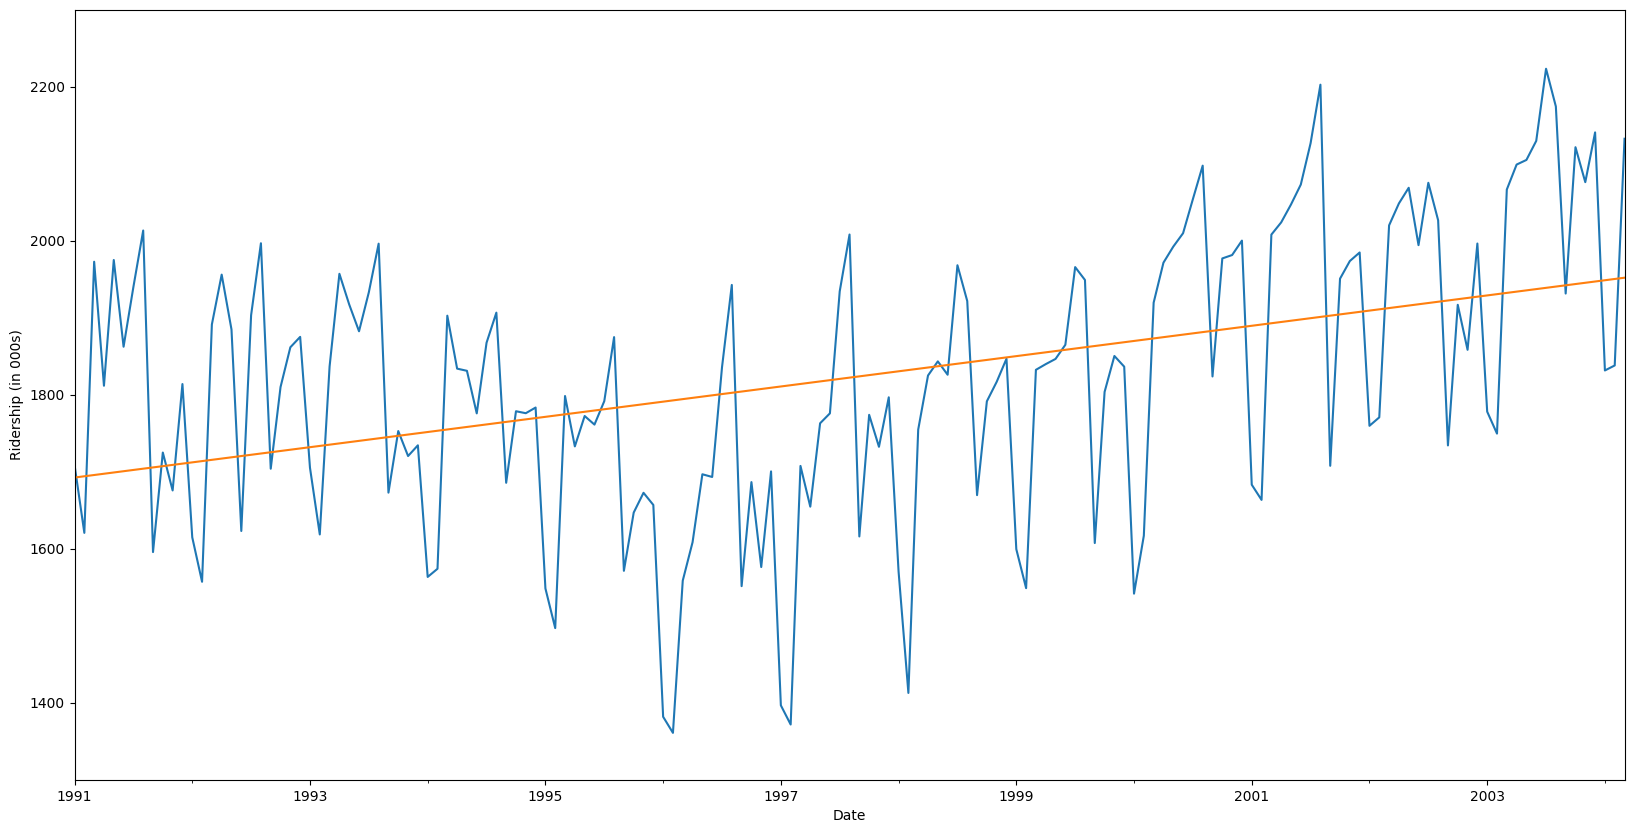

In [9]:
# load data and convert to time series
Amtrak_df = pd.read_csv('Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format = '%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index = Amtrak_df.Date,name = 'Ridership')

# fit a linear trend model to the time series
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_lm = sm.ols(formula = 'Ridership ~ trend', data = ridership_df).fit()

# plot the time series
plt.figure(figsize=(20,10))
ax = ridership_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300,2300)
ridership_lm.predict(ridership_df).plot(ax=ax)
plt.show()

In [14]:
ridership_df.loc[:'1992-02-01',['Ridership','trend']]

,Ridership,trend
Date,,
1991-01-01,1708.917,1.0
1991-02-01,1620.586,2.0
1991-03-01,1972.715,3.0
1991-04-01,1811.665,4.0
1991-05-01,1974.964,5.0
1991-06-01,1862.356,6.0
1991-07-01,1939.860,7.0
1991-08-01,2013.264,8.0
1991-09-01,1595.657,9.0


# 데이터를 Partitioning 한 이후 Training Set에 대해서 Fitting 후 Validation Set에 해당하는 기간을 예측

In [17]:
nValid = 36
nTrain = len(ridership_ts) - nValid

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

train_df

,Ridership,const,trend
Date,,,
1991-01-01,1708.917,1.0,1.0
1991-02-01,1620.586,1.0,2.0
1991-03-01,1972.715,1.0,3.0
1991-04-01,1811.665,1.0,4.0
1991-05-01,1974.964,1.0,5.0
...,...,...,...
2000-11-01,1981.408,1.0,119.0
2000-12-01,2000.153,1.0,120.0
2001-01-01,1683.148,1.0,121.0


In [20]:
# create the plot
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990','2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')

    # x좌표지정
    xtrain = (min(train_df.index), max(train_df.index)-one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index)-one_month)

    # 수직선 x좌표
    # train-validation
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos,ypos), c = 'black', linewidth = 0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos,ypos), c = 'black', linewidth = 0.5))
    ax.axvline(x=xtv, ymin = 0, ymax = 1, color = 'black', linewidth = 0.5)
    
    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995',ypos,'Training')
    ax.text('2002-3',ypos,'Validation')

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0],[1300,2550],train_df,valid_df)
    singleGraphLayout(axes[1],[-550,550],train_df,valid_df)
    train_df.plot(y = 'Ridership', ax = axes[0], color = 'C0', linewidth = 0.75)
    valid_df.plot(y = 'Ridership', ax = axes[0], color = 'C0', linestyle = 'dashed', linewidth = 0.75)
    axes[1].axhline(y = 0, xmin = 0, xmax = 1, color = 'black', linewidth = 0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend():
        axes[0].get_legend().remove()

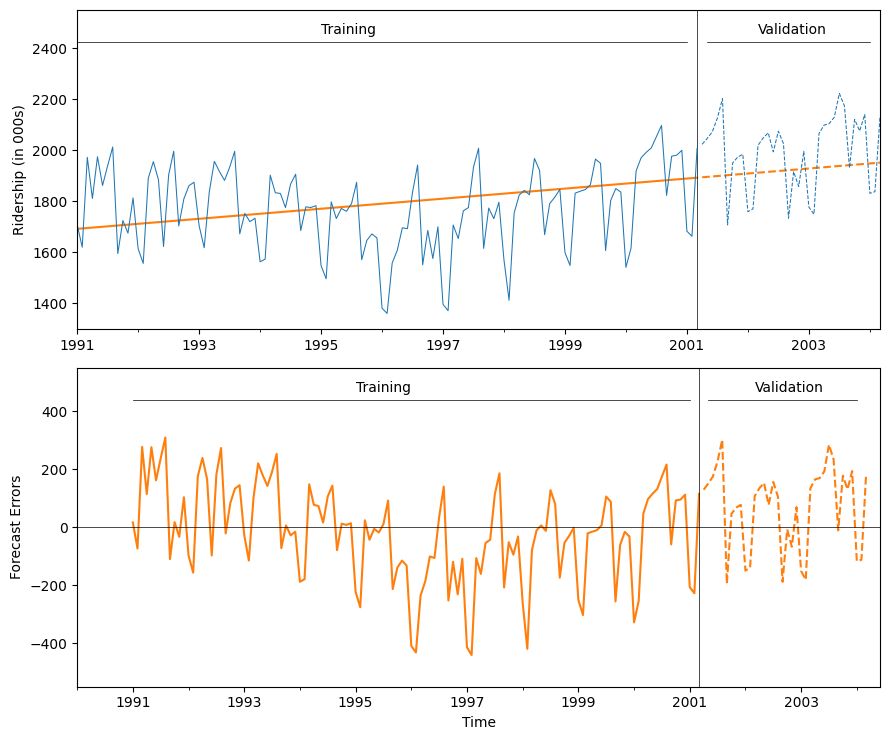

In [21]:
fig,axes = plt.subplots(nrows = 2, ncols = 1, figsize = (9,7.5))
ridership_lm.predict(train_df).plot(ax = axes[0], color = 'C1')
ridership_lm.predict(valid_df).plot(ax = axes[0], color = 'C1', linestyle = 'dashed')

residual = train_df.Ridership - ridership_lm.predict(train_df)
residual.plot(ax = axes[1],color = 'C1')
residual = valid_df.Ridership - ridership_lm.predict(valid_df)
residual.plot(ax=axes[1], color = 'C1', linestyle = 'dashed')
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

## Note

In [24]:
ridership_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     32.92
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           4.80e-08
Time:                        18:07:55   Log-Likelihood:                -1037.1
No. Observations:                 159   AIC:                             2078.
Df Residuals:                     157   BIC:                             2084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1690.7983     26.401     64.042      0.000    1638.651    1742.946
trend          1.6425      0.286      5.738      0.000       1.077       2.208
==============================================================================
Omnibus:                        5.856   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                6.031
Skew:                          -0.463   Prob(JB):                       0.0490
Kurtosis:                       2.771   Cond. No.                         185.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 암트랙 승객 수 데이터의 지수 추세 그래프

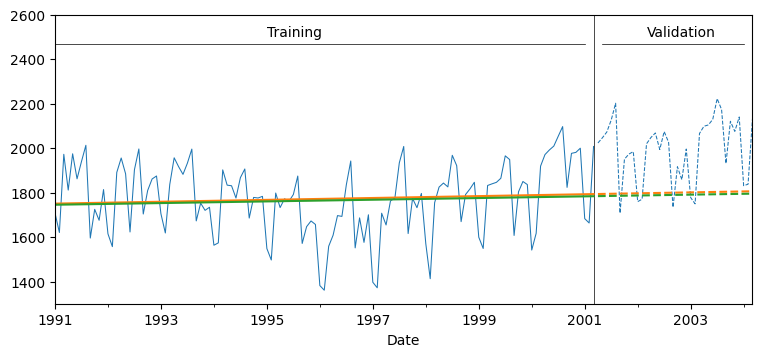

In [25]:
ridership_lm_linear = sm.ols(formula = 'Ridership ~ trend', data = train_df).fit()
predict_df_linear = ridership_lm_linear.predict(valid_df)

ridership_lm_expo = sm.ols(formula = 'np.log(Ridership) ~ trend', data = train_df).fit()
predict_df_expo = ridership_lm_expo.predict(valid_df)

fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (9,3.75))
train_df.plot(y = 'Ridership', ax = ax, color = 'C0', linewidth = 0.75)
valid_df.plot(y = 'Ridership', ax = ax, color = 'C0', linestyle = 'dashed', linewidth = 0.75)
singleGraphLayout(ax, [1300, 2600], train_df, valid_df)
ridership_lm_linear.predict(train_df).plot(color = 'C1')
ridership_lm_linear.predict(valid_df).plot(color = 'C1', linestyle = 'dashed')
ridership_lm_expo.predict(train_df).apply(lambda row: math.exp(row)).plot(color = 'C2')
ridership_lm_expo.predict(valid_df).apply(lambda row: math.exp(row)).plot(color = 'C2', linestyle = 'dashed')

ax.get_legend().remove()
plt.show()

# 암트랙 승객 수 데이터의 2차 추세 그래프

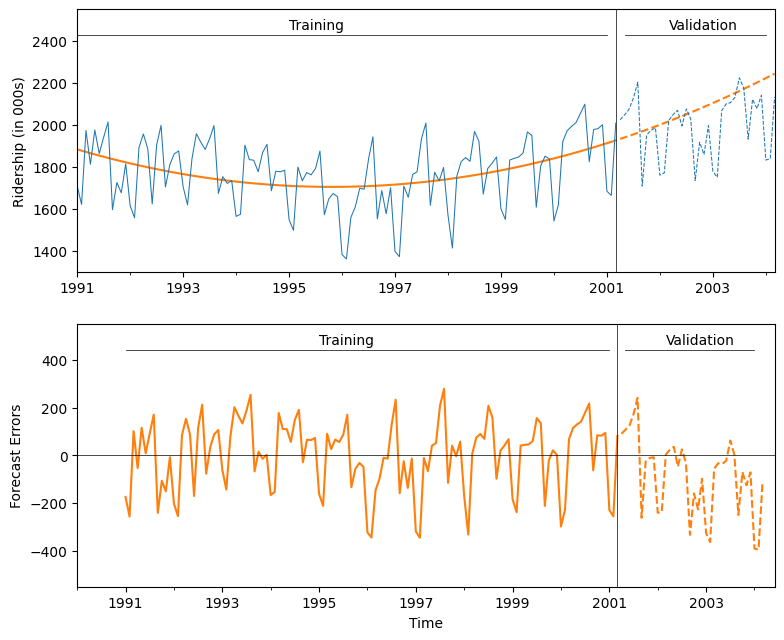

In [26]:
ridership_lm_poly = sm.ols(formula = 'Ridership ~ trend + np.square(trend)', data = train_df).fit()

fig, axes = plt.subplots(nrows = 2, ncols=1, figsize = (9, 7.5))

ridership_lm_poly.predict(train_df).plot(ax = axes[0], color = 'C1')
ridership_lm_poly.predict(valid_df).plot(ax = axes[0], color = 'C1', linestyle = 'dashed')

residual = train_df.Ridership - ridership_lm_poly.predict(train_df)
residual.plot(ax = axes[1], color = 'C1')
residual = valid_df.Ridership - ridership_lm_poly.predict(valid_df)
residual.plot(ax = axes[1], color = 'C1', linestyle = 'dashed')

graphLayout(axes, train_df, valid_df)
plt.show()

# 계절성을 반영한 모델

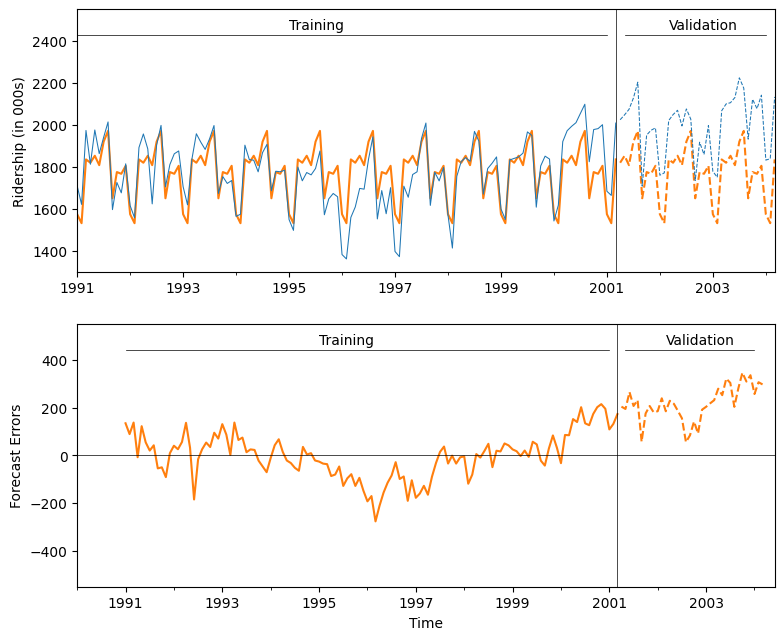

In [27]:
ridership_df = tsatools.add_trend(ridership_ts, trend = 'c')
ridership_df['Month'] = ridership_df.index.month

# Partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]
ridership_lm_season = sm.ols(formula = 'Ridership ~ C(Month)', data = train_df).fit()

fig, axes = plt.subplots(nrows = 2, ncols=1, figsize = (9, 7.5))

ridership_lm_season.predict(train_df).plot(ax = axes[0], color = 'C1')
ridership_lm_season.predict(valid_df).plot(ax = axes[0], color = 'C1', linestyle = 'dashed')

residual = train_df.Ridership - ridership_lm_season.predict(train_df)
residual.plot(ax = axes[1], color = 'C1')
residual = valid_df.Ridership - ridership_lm_season.predict(valid_df)
residual.plot(ax = axes[1], color = 'C1', linestyle = 'dashed')

graphLayout(axes, train_df, valid_df)
plt.show()

In [28]:
ridership_lm_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     17.54
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           1.20e-19
Time:                        20:27:10   Log-Likelihood:                -736.38
No. Observations:                 123   AIC:                             1497.
Df Residuals:                     111   BIC:                             1531.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1573.9722     30.578     51.475      0.000    1513.381    1634.564
C(Month)[T.2]    -42.9302     43.243     -0.993      0.323    -128.620      42.759
C(Month)[T.3]    260.7677     43.243      6.030      0.000     175.078     346.457
C(Month)[T.4]    245.0919     44.311      5.531      0.000     157.286     332.897
C(Month)[T.5]    278.2222     44.311      6.279      0.000     190.417     366.028
C(Month)[T.6]    233.4598     44.311      5.269      0.000     145.654     321.265
C(Month)[T.7]    345.3265     44.311      7.793      0.000     257.521     433.132
C(Month)[T.8]    396.6595     44.311      8.952      0.000     308.854     484.465
C(Month)[T.9]     75.7615     44.311      1.710      0.090     -12.044     163.567
C(Month)[T.10]   200.6076     44.311      4.527      0.000     112.802     288.413
C(Month)[T.11]   192.3552     44.311      4.341      0.000     104.550     280.161
C(Month)[T.12]   230.4151     44.311      5.200      0.000     142.610     318.221
==============================================================================
Omnibus:                        0.495   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.781   Jarque-Bera (JB):                0.452
Skew:                          -0.145   Prob(JB):                        0.798
Kurtosis:                       2.937   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
train_df[train_df['Month']==1]['Ridership'].mean()

1573.9721818181818

In [42]:
train_df[train_df['Month']==8]['Ridership'].mean()

1970.6317

In [45]:
1970.6317 - 1573.9721818181818

396.65951818181816

# 추세와 계절성을 반영한 모델

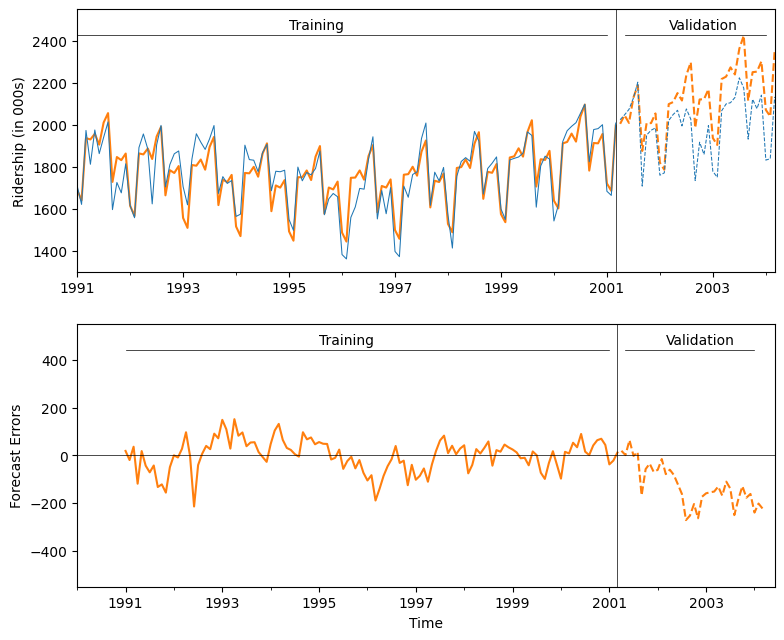

In [47]:
ridership_df = tsatools.add_trend(ridership_ts, trend = 'ctt')
ridership_df['Month'] = ridership_df.index.month

# Partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

ridership_lm_trendseason = sm.ols(formula = 'Ridership ~ C(Month) + trend + trend_squared',
                             data = train_df).fit()

fig, axes = plt.subplots(nrows = 2, ncols=1, figsize = (9, 7.5))

ridership_lm_trendseason.predict(train_df).plot(ax = axes[0], color = 'C1')
ridership_lm_trendseason.predict(valid_df).plot(ax = axes[0], color = 'C1', linestyle = 'dashed')

residual = train_df.Ridership - ridership_lm_trendseason.predict(train_df)
residual.plot(ax = axes[1], color = 'C1')
residual = valid_df.Ridership - ridership_lm_trendseason.predict(valid_df)
residual.plot(ax = axes[1], color = 'C1', linestyle = 'dashed')

graphLayout(axes, train_df, valid_df)
plt.show()

In [48]:
ridership_lm_trendseason.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ridership   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.42
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           3.75e-35
Time:                        21:00:41   Log-Likelihood:                -691.27
No. Observations:                 123   AIC:                             1411.
Df Residuals:                     109   BIC:                             1450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1696.9794     27.675     61.318      0.000    1642.128    1751.831
C(Month)[T.2]    -43.2458     30.241     -1.430      0.156    -103.182      16.690
C(Month)[T.3]    260.0149     30.242      8.598      0.000     200.076     319.954
C(Month)[T.4]    260.6175     31.021      8.401      0.000     199.135     322.100
C(Month)[T.5]    293.7966     31.020      9.471      0.000     232.316     355.278
C(Month)[T.6]    248.9615     31.020      8.026      0.000     187.481     310.442
C(Month)[T.7]    360.6340     31.020     11.626      0.000     299.153     422.115
C(Month)[T.8]    411.6513     31.021     13.270      0.000     350.169     473.134
C(Month)[T.9]     90.3162     31.022      2.911      0.004      28.831     151.801
C(Month)[T.10]   214.6037     31.024      6.917      0.000     153.115     276.092
C(Month)[T.11]   205.6711     31.026      6.629      0.000     144.178     267.165
C(Month)[T.12]   242.9294     31.029      7.829      0.000     181.430     304.429
trend             -7.1559      0.729     -9.812      0.000      -8.601      -5.710
trend_squared      0.0607      0.006     10.660      0.000       0.049       0.072
==============================================================================
Omnibus:                        7.382   Durbin-Watson:                   0.791
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                6.974
Skew:                          -0.529   Prob(JB):                       0.0306
Kurtosis:                       3.492   Cond. No.                     8.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# lag 이해하기

In [163]:
temp = ridership_df.loc[:'1992-12-01',['Ridership']].copy()
temp['Ridership'] = np.round(temp['Ridership'].values).astype(np.int64)
temp['Lag-1 series'] = np.insert(np.round(temp.iloc[:-1,0].values),0,0).astype(np.int64)
temp['Lag-2 series'] = np.insert(np.round(temp.iloc[:-2,0].values),[0,0],0).astype(np.int64)
temp.replace(0,'',inplace = True)
temp

,Ridership,Lag-1 series,Lag-2 series
Date,,,
1991-01-01,1709,,
1991-02-01,1621,1709,
1991-03-01,1973,1621,1709
1991-04-01,1812,1973,1621
1991-05-01,1975,1812,1973
1991-06-01,1862,1975,1812
1991-07-01,1940,1862,1975
1991-08-01,2013,1940,1862
1991-09-01,1596,2013,1940


# Lag-1 Series와  Ridership 사이의 Correlation 구하기

In [174]:
np.corrcoef(temp['Ridership'].values[1:],temp['Ridership'].values[:-1],rowvar = True)[0,1]

0.08088924054930341

In [162]:
np.corrcoef(temp['Ridership'].values[2:],temp['Ridership'].values[:-2])[0,1]

-0.14937715169919857

# statsmodels의 `acf()`와 `plot_acf()`를 통해 다양한 lagged value 확인하기

In [165]:
from statsmodels.tsa.stattools import acf

In [177]:
acf(temp['Ridership'],nlags=3,fft=False)

array([ 1.        ,  0.07896511, -0.14350059, -0.00216512])

* **두번째 인덱스에 있는게 lag-1에 대한 결과이고 위의 결과와 다른 이유는 아래와 같다.**
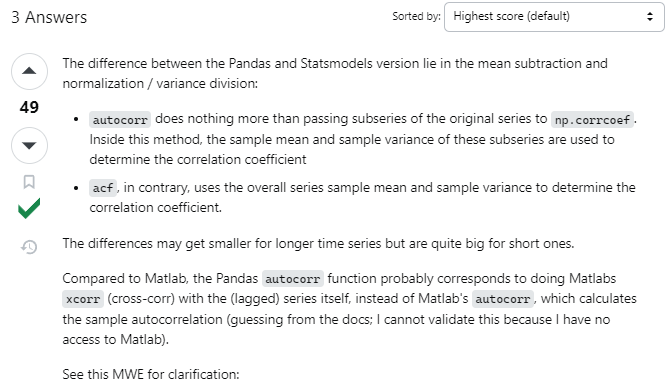
* **요약하자면, Auto-correlation을 계산하는 과정에 있어서 분모에 사용하는 평균과 분산을 Sample을 뽑아서 평균 분산을 계산할 것인지 아니면 모든 Sample에 대해서 평균 분산을 계산할 것인지의 차이가 있다.**<br>
[출처](https://stackoverflow.com/questions/36038927/whats-the-difference-between-pandas-acf-and-statsmodel-acf)

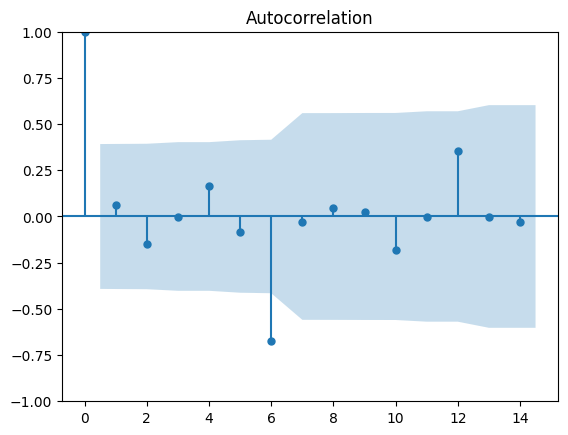

In [164]:
tsaplots.plot_acf(train_df['1991-01-01':'1993-01-01'].Ridership)
plt.show()

<Axes: xlabel='Date'>

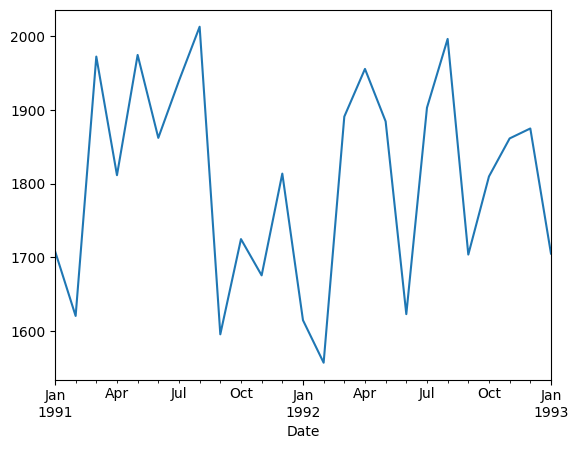

In [187]:
train_df['1991-01-01':'1993-01-01'].Ridership.plot()

# 잔차의 ACF plot 그리기

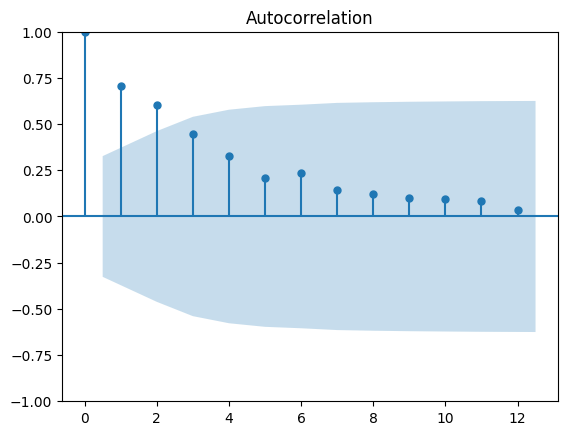

In [193]:
tsaplots.plot_acf(residual,lags=12);

# 암트랙 데이터에 AR(1) 모델 적용하기

In [213]:
formula = 'Ridership ~ trend + np.square(trend) + C(Month)'
train_lm_trendseason = sm.ols(formula = formula, data = train_df).fit()
train_res_arima = ARIMA(train_lm_trendseason.resid, order = (1,0,0),trend = 'n',freq = 'MS').fit()
# ARIMA(p,d,q)로  p가 의미하는 것이 AR(p)의 차수이다.
forecast = train_res_arima.forecast(1)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [214]:
forecast

2001-04-01    7.261897
Freq: MS, dtype: float64

In [215]:
train_res_arima.params

ar.L1        0.599782
sigma2    2829.299413
dtype: float64

* AR(1) 모델을 적용함으로써 성능 향상 관측하기

In [227]:
print('예측 값: ', ridership_lm_trendseason.predict(valid_df)[0])
print('예측 값 + AR(1): ',ridership_lm_trendseason.predict(valid_df)[0] + forecast.values[0])
print('실제 값: ', valid_df.iloc[0]['Ridership'].item())

예측 값:  2004.270892764497
예측 값 + AR(1):  2011.5327895726225
실제 값:  2023.792


# Training 데이터에 대해 잔차 Plot 그리기
* 이는 이전에 2차추세와 Seasonality를 반영한 모델에 대해서 AR(1)을 이용해 잔차를 Forecasting 한 것이다.
* 주황색이 Forecasting 잔차 파란색이 실제 잔차이다.

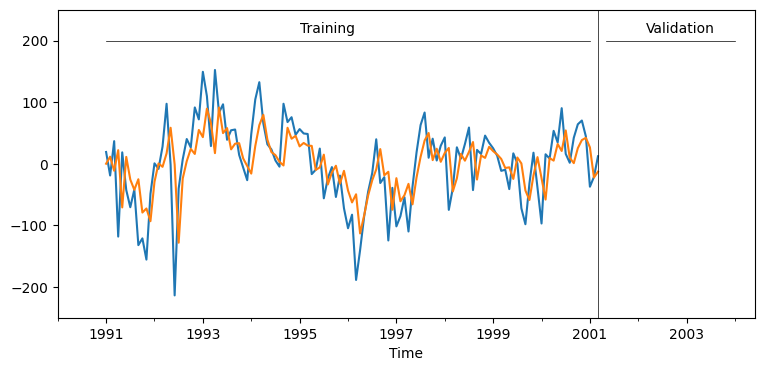

In [230]:
ax = train_lm_trendseason.resid.plot(figsize = (9,4))
train_res_arima.fittedvalues.plot(ax=ax)
singleGraphLayout(ax,[-250,250],train_df,valid_df)
plt.show()

# 잔차의 잔차(residuals-of-residuals) 구하기

In [237]:
resid_of_resid = train_lm_trendseason.resid - train_res_arima.fittedvalues
resid_of_resid

Date
1991-01-01     19.032747
1991-02-01    -30.494293
1991-03-01     48.084696
1991-04-01   -140.257278
1991-05-01     89.391152
                 ...    
2000-11-01     31.719024
2000-12-01      2.183273
2001-01-01    -63.856240
2001-02-01      0.958307
2001-03-01     24.960441
Length: 123, dtype: float64

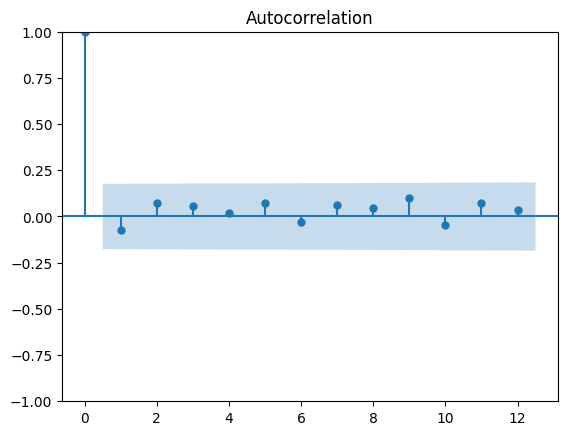

In [238]:
tsaplots.plot_acf(resid_of_resid,lags=12);

# S&P 500 데이터에 AR(1)이 유의미한지 확인하기

In [247]:
sp500_df = pd.read_csv('SP500.csv')
# convert date to first of each month

sp500_df['Date'] = pd.to_datetime(sp500_df.Date, format = '%d-%b-%y').dt.to_period('M')
sp500_ts = pd.Series(sp500_df.Close.values, index = sp500_df.Date, name = 'sp500')
sp500_arima = ARIMA(sp500_ts, order = (1,0,0)).fit()

In [248]:
print("coef: ",sp500_arima.params['ar.L1'])
print('standard deviation: ',sp500_arima.bse['ar.L1'])

coef:  0.9833602668735888
standard deviation:  0.015866523792147272


# Appendix> pmdarima라이브러리의 auto_arima 사용하기
* ARIMA가 아닌 SARIMAX를 사용하도록 모델이 Fitting 됨
* 위에서 가장 좋은 성능을 보인 2차 추세 + 계절성 모델또한 외부 변수를 사용함

In [251]:
from pmdarima import auto_arima

In [261]:
train_df

,Ridership,const,trend,trend_squared,Month
Date,,,,,
1991-01-01,1708.917,1.0,1.0,1.0,1
1991-02-01,1620.586,1.0,2.0,4.0,2
1991-03-01,1972.715,1.0,3.0,9.0,3
1991-04-01,1811.665,1.0,4.0,16.0,4
1991-05-01,1974.964,1.0,5.0,25.0,5
...,...,...,...,...,...
2000-11-01,1981.408,1.0,119.0,14161.0,11
2000-12-01,2000.153,1.0,120.0,14400.0,12
2001-01-01,1683.148,1.0,121.0,14641.0,1


In [273]:
arima = auto_arima(train_df['Ridership'].values,X = train_df.iloc[:,2:].values,
                   trace = True,m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1438.318, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1887.646, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1446.174, Time=0.58 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1713.743, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1905.293, Time=0.08 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1562.958, Time=0.42 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1464.434, Time=0.49 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=1430.597, Time=2.06 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=1524.594, Time=1.51 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=1429.771, Time=1.83 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=1496.263, Time=1.48 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=1429.123, Time=0.51 sec
 ARIMA(1,0,2)(0,0,1)[12] inte

In [274]:
arima.predict(36, X=valid_df.iloc[:,2:].values)

array([2025.86595157, 2057.68665541, 2055.73912351, 2157.40663151,
       2193.15089494, 1894.39398242, 2041.10650466, 2048.07437031,
       2079.90639065, 1805.919203  , 1787.54675828, 2098.10819898,
       2122.05716243, 2157.9550686 , 2157.52652419, 2260.07798861,
       2297.11110379, 2001.69536144, 2149.01713113, 2157.45195079,
       2190.59894204, 1916.56217415, 1899.81370918, 2209.98202126,
       2235.29643129, 2272.48702123, 2273.57451296, 2377.01087768,
       2415.33130492, 2123.24260441, 2271.17625053, 2281.07539212,
       2315.53565449, 2041.45597658, 2026.32789619, 2336.11185718])

# SARIMAX결과
**2025.866으로 이전보다 실제 값: 2023.792과 더욱 유사해진 것을 확인할 수 있다**